# NARX GP Grid Search

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Product

from scipy.sparse import csr_matrix

from data import load_narx_data, load_data
from util_fun import calculate_error_nrms, use_NARX_model_in_simulation, plot_NRMS_Pred_vs_Sim

In [2]:
# Initialize stationary parameters

Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 5000 # total number of points to consider from the larger dataset (starting from index 0)

na_list=[*range(2,11)]
nb_list=[*range(2,10)]
restarts = 0

Save_data = False
Load_data = True

val_pred_NRMSs=np.ndarray((len(na_list),len(nb_list)))
val_sim_NRMSs=np.ndarray((len(na_list),len(nb_list)))

## Define your kernel here

In [3]:
kernel = RBF(length_scale_bounds=[1,30]) + WhiteKernel(noise_level_bounds=[1e-7,1e-1])
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=restarts)

In [4]:
#Load normal data
Xtrain,Ytrain = load_data(section="train", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xval,Yval = load_data(section="validation", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)

Using 3000 datapoints for training set


In [5]:
bestNRMSsim = float('inf')

In [6]:
if not Load_data:
    for i, n_a in enumerate(na_list):
        for j, n_b in enumerate(nb_list):

            print(f"Currently running: na= {n_a}, nb= {n_b}")

            #Construct NARX data
            Xtrain_NARX,Ytrain_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=False)
            Xval_NARX,Yval_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)


            #Convert to sparce matrices
            XtrainSparse = csr_matrix(Xtrain_NARX).toarray()
            YtrainSparse = csr_matrix(Ytrain_NARX).toarray().transpose()

            #Fit the GP
            reg.fit(XtrainSparse, YtrainSparse)

            #Initialize parameters for simulation
            fmodel = lambda u,y: reg.predict(np.concatenate([u,y])[None,:])[0] 

            #Prediction on validation set
            Yval_pred, Yval_pred_std = reg.predict(Xval_NARX,return_std=True)

            #Simulation on validation set
            Yval_sim = use_NARX_model_in_simulation(Xval, fmodel, n_a, n_b)


            #Store results
            val_pred_NRMSs[i,j] = calculate_error_nrms(Yval_pred, Yval_NARX)
            val_sim_NRMSs[i,j] = calculate_error_nrms(Yval_sim, Yval)

            print(f"NRMS for validation is: pred= {val_pred_NRMSs[i,j]:.2f}, sim= {val_sim_NRMSs[i,j]:.2f}")

            if val_sim_NRMSs[i,j] < bestNRMSsim:
                bestNRMSsim = val_sim_NRMSs[i,j]
                print(f"BEST NRMS currently is: na= {n_a}, nb= {n_b}")

# Validation data

In [7]:
if Save_data:
    np.savez('val_pred_NRMSs', val_pred_NRMSs)
    np.savez('val_sim_NRMSs', val_sim_NRMSs)
    
if Load_data:
    val_pred_NRMSs = np.load('val_pred_NRMSs.npz')['arr_0']
    val_sim_NRMSs = np.load('val_sim_NRMSs.npz')['arr_0']

C:\Users\20193261\Desktop\5SC28\Project\Hand_in\5SC28\__01_system_id\NARX_GP\util_fun.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0]+na_list)
C:\Users\20193261\Desktop\5SC28\Project\Hand_in\5SC28\__01_system_id\NARX_GP\util_fun.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0]+na_list)


Best parameters by prediction NRMS: na= 8, nb= 3
Best parameters by simulation NRMS: na= 6, nb= 3


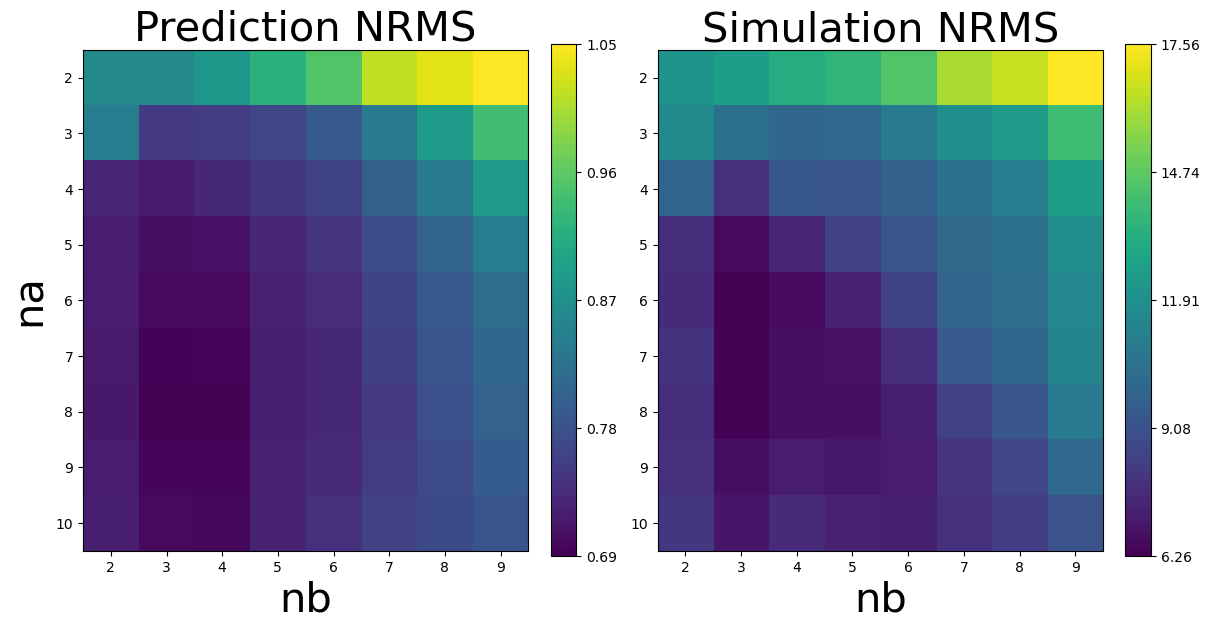

In [8]:
best_na_nb_val_pred, best_na_nb_val_sim = plot_NRMS_Pred_vs_Sim(val_pred_NRMSs, val_sim_NRMSs, na_list, nb_list, figsize=(12, 12), Save = True)

In [9]:
print(f"Best val prediction NRMS found: {val_pred_NRMSs.min()}")
print(f"Best val simulation NRMS found: {val_sim_NRMSs.min()}")

Best val prediction NRMS found: 0.6929288709239905
Best val simulation NRMS found: 6.257302430383503


## Find the test NRMS for the test dataset

In [10]:
n_a, n_b = 8,3
total_number_of_points = 5000

# Load normal data
Xtrain,Ytrain = load_data(section="train", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xval,Yval = load_data(section="validation", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xtest,Ytest = load_data(section="test", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)

#Construct NARX data
Xtrain_NARX,Ytrain_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=False)
Xval_NARX,Yval_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)
Xtest_NARX,Ytest_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=False)

#Convert to sparce matrices
XtrainSparse = csr_matrix(Xtrain_NARX).toarray()
YtrainSparse = csr_matrix(Ytrain_NARX).toarray().transpose()

#Fit the GP
reg.fit(XtrainSparse, YtrainSparse)

#Initialize parameters for simulation
fmodel = lambda u,y: reg.predict(np.concatenate([u,y])[None,:])[0] 

#Prediction on training set
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain_NARX,return_std=True)
#Simulation on training set
Ytrain_sim = use_NARX_model_in_simulation(Xtrain, fmodel, n_a, n_b)

#Prediction on validation set
Yval_pred, Yval_pred_std = reg.predict(Xval_NARX,return_std=True)
#Simulation on validation set
Yval_sim = use_NARX_model_in_simulation(Xval, fmodel, n_a, n_b)

#Prediction on test set
Ytest_pred, Ytest_pred_std = reg.predict(Xtest_NARX,return_std=True)
#Simulation on test set
Ytest_sim = use_NARX_model_in_simulation(Xtest, fmodel, n_a, n_b)


Using 3000 datapoints for training set
Using 3000 datapoints for training set


In [11]:
NRMS_train_pred = calculate_error_nrms(Ytrain_pred, Ytrain_NARX)
print(f'Train prediction NRMS: {NRMS_train_pred:.2f} %')

NRMS_train_sim = calculate_error_nrms(Ytrain_sim, Ytrain)
print(f'Train simulation NRMS: {NRMS_train_sim:.2f} %')

NRMS_val_pred = calculate_error_nrms(Yval_pred, Yval_NARX)
print(f'Validation prediction NRMS: {NRMS_val_pred:.2f} %')

NRMS_val_sim = calculate_error_nrms(Yval_sim, Yval)
print(f'Validation simulation NRMS: {NRMS_val_sim:.2f} %')

NRMS_test_pred = calculate_error_nrms(Ytest_pred, Ytest_NARX)
print(f'Test prediction NRMS: {NRMS_test_pred:.2f} %')

NRMS_test_sim = calculate_error_nrms(Ytest_sim, Ytest)
print(f'Test simulation NRMS: {NRMS_test_sim:.2f} %')

Train prediction NRMS: 0.73 %
Train simulation NRMS: 5.47 %
Validation prediction NRMS: 0.69 %
Validation simulation NRMS: 6.33 %
Test prediction NRMS: 0.77 %
Test simulation NRMS: 9.48 %


In [12]:
data = {
    'Prediction': [NRMS_train_pred, NRMS_val_pred, NRMS_test_pred],
    'Simulation': [NRMS_train_sim, NRMS_val_sim, NRMS_test_sim]
}
    
index = ['Train', 'Validation', 'Test']

df = pd.DataFrame(data, index=index)

df = df.round(2)

display(df)


,Prediction,Simulation
Train,0.73,5.47
Validation,0.69,6.33
Test,0.77,9.48
